###### InternVL3.5-8B Document Extraction

**Primary notebook for InternVL3.5-8B vision-language model document extraction.**

**Model**: InternVL3.5-8B (8.5B parameters: 0.3B vision + 8.2B language)

**Features:**
- Cascade Reinforcement Learning (Cascade RL) for enhanced reasoning
- Visual Resolution Router (ViR) for dynamic resolution adjustment
- Flash Attention 2 support
- Sophisticated bank statement extraction with multi-turn processing

**Requirements**: 
- `transformers>=4.52.1` (critical for InternVL3.5 support)
- PyTorch with CUDA support
- H200/H100/A100 GPU (native bfloat16) or V100 (float32)

**Configuration:**
- `USE_SOPHISTICATED_BANK_EXTRACTION`: True (default) uses multi-turn extraction
- `ENABLE_BALANCE_CORRECTION`: Optional mathematical balance validation

## 1. Imports

In [1]:
#Cell 1
# Project root setup - notebook is at project root
import os
import sys
from pathlib import Path

os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'

# Project root is current directory (notebook at root)
PROJECT_ROOT = Path().absolute()
print(f"📂 Project root: {PROJECT_ROOT}")

# Ensure the project root is in the Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    print(f"✅ Added {PROJECT_ROOT} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    raise

print("✅ Path setup complete")

📂 Project root: /home/jovyan/nfs_share/tod_2026/LMM_POC
✅ Added /home/jovyan/nfs_share/tod_2026/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod_2026/LMM_POC/common/__init__.py
✅ Path setup complete


## 2. Imports and Dependencies

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# V2: Sophisticated bank statement processing
from common.bank_statement_adapter import BankStatementAdapter

# Project-specific imports - consistent with ivl3_cli.py
from common.batch_analytics import BatchAnalytics
from common.batch_processor import (
    BatchDocumentProcessor,
    load_document_field_definitions,
)
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.gpu_optimization import emergency_cleanup
from common.pipeline_config import discover_images
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Batch processing modules imported successfully")
print("✅ V2: BankStatementAdapter imported for sophisticated bank extraction")
print("✅ load_document_field_definitions imported for YAML config")
print(f"📂 Working directory: {notebook_dir}")
print("🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router")
warnings.filterwarnings('ignore')

✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Batch processing modules imported successfully
✅ V2: BankStatementAdapter imported for sophisticated bank extraction
✅ load_document_field_definitions imported for YAML config
📂 Working directory: /home/jovyan/nfs_share/tod_2026/LMM_POC
🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router


## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running emergency GPU cleanup...
🧹 Starting GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ GPU memory cleanup complete
✅ Emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [4]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod_2026',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings - InternVL3.5-8B
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3_5-8B',
    # Alternative paths:
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3_5-8B',
    # 'MODEL_PATH': 'OpenGVLab/InternVL3_5-8B',  # Auto-download from HuggingFace

    # Batch settings - Using base path for consistency
    # 'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data/travel/logbooks',
    # 'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/travel/logbooks/ground_truth_logbook.csv',
    'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data/synthetic',
    'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv',

    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Batch inference settings (consistent with ivl3_cli.py --batch-size)
    'BATCH_SIZE': None,  # None for auto-detect from VRAM, or set explicitly
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: False (evaluation mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # ============================================================================
    # H200 BFLOAT16 CONFIGURATION - OPTIMAL PERFORMANCE BASELINE
    # ============================================================================
    'USE_QUANTIZATION': False,  # Full precision for H200
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,
    'TORCH_DTYPE': 'bfloat16',  # Native H200 support
    'LOW_CPU_MEM_USAGE': False,  # Must be False - InternVL3.5 vision encoder incompatible with meta device init
    'USE_FLASH_ATTN': True,  # H200 optimized - faster inference
    'USE_TORCH_COMPILE': False,
    'MAX_TILES': 11,  # H200 optimized - InternVL3.5 training max for dense OCR
    
    # ============================================================================
    # V2: SOPHISTICATED BANK STATEMENT EXTRACTION
    # ============================================================================
    'USE_SOPHISTICATED_BANK_EXTRACTION': True,
    'ENABLE_BALANCE_CORRECTION': True,
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Uses PROJECT_ROOT for subdirectory compatibility
# ============================================================================
PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': str(PROJECT_ROOT / 'prompts/document_type_detection.yaml'),
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'RECEIPT': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'BANK_STATEMENT': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'TRAVEL_EXPENSE': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'VEHICLE_LOGBOOK': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
    },
}

# ============================================================================
# FIELD DEFINITIONS - LOADED FROM YAML (SINGLE SOURCE OF TRUTH)
# ============================================================================
# Load document-type-specific field lists from config/field_definitions.yaml
# This replaces the hardcoded UNIVERSAL_FIELDS list to ensure consistency
# across all components (processor, evaluation, CSV output).
# ============================================================================
DOCUMENT_FIELD_DEFINITIONS = load_document_field_definitions()

# Create a union of all fields for multi-document-type batches
# This is used for CSV column headers when processing mixed document types
ALL_FIELDS = set()
for doc_type, fields in DOCUMENT_FIELD_DEFINITIONS.items():
    ALL_FIELDS.update(fields)
ALL_FIELDS = sorted(list(ALL_FIELDS))

# For backwards compatibility, UNIVERSAL_FIELDS is now the union of all fields
UNIVERSAL_FIELDS = ALL_FIELDS

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print("🤖 Model: InternVL3.5-8B")
print(f"📁 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"🏠 Project root: {PROJECT_ROOT}")
print("📋 Field definitions loaded from YAML:")
for doc_type, fields in DOCUMENT_FIELD_DEFINITIONS.items():
    print(f"   - {doc_type}: {len(fields)} fields")
print(f"📋 Universal fields (union): {len(UNIVERSAL_FIELDS)}")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"⚙️  Precision: {CONFIG['TORCH_DTYPE'].upper()}")
print(f"⚡ Flash Attention: {'ENABLED' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED'}")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']}")
print(f"📦 Batch Size: {CONFIG['BATCH_SIZE'] or 'auto'}")
print(f"🏦 V2 Bank Extraction: {'Enabled' if CONFIG['USE_SOPHISTICATED_BANK_EXTRACTION'] else 'Disabled'}")
print(f"🔥 torch.compile: {'ENABLED' if CONFIG['USE_TORCH_COMPILE'] else 'DISABLED'}")

✅ Configuration set up successfully
📂 Evaluation data: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/synthetic
📊 Ground truth: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv
🤖 Model: InternVL3.5-8B
📁 Model path: /home/jovyan/nfs_share/models/InternVL3_5-8B
📁 Output base: /home/jovyan/nfs_share/tod_2026/LMM_POC/output
🏠 Project root: /home/jovyan/nfs_share/tod_2026/LMM_POC
📋 Field definitions loaded from YAML:
   - invoice: 14 fields
   - receipt: 14 fields
   - bank_statement: 5 fields
   - travel_expense: 9 fields
   - vehicle_logbook: 15 fields
📋 Universal fields (union): 35
🎯 Mode: Evaluation mode
⚙️  Precision: BFLOAT16
⚡ Flash Attention: ENABLED
🔲 Max Tiles: 11
📦 Batch Size: auto
🏦 V2 Bank Extraction: Enabled
🔥 torch.compile: DISABLED


# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading

**InternVL3.5-8B**: Loading the latest InternVL3.5 model with Cascade RL and Visual Resolution Router.

**Requirements**: Ensure `transformers>=4.52.1` is installed for InternVL3.5 compatibility.

In [6]:
#Cell 6
# Load InternVL3.5-8B model
# Model page: https://huggingface.co/OpenGVLab/InternVL3_5-8B
# Using official loading pattern from HuggingFace model card

rprint("[bold green]Loading InternVL3.5-8B model...[/bold green]")
rprint("[cyan]🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)[/cyan]")
rprint("[cyan]📖 Features: Cascade RL, Visual Resolution Router (ViR)[/cyan]")

# Resolve torch dtype from config string (consistent with ivl3_cli.py)
TORCH_DTYPE = getattr(torch, CONFIG['TORCH_DTYPE'])

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    world_size = torch.cuda.device_count()
    rprint(f"[cyan]🖥️  Detected {world_size} GPU(s)[/cyan]")
    rprint("[cyan]📥 Loading model (official HuggingFace pattern)...[/cyan]")
    
    # Official loading pattern from https://huggingface.co/OpenGVLab/InternVL3_5-8B
    # Using device_map='auto' for multi-GPU distribution
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=TORCH_DTYPE,
        low_cpu_mem_usage=True,
        use_flash_attn=CONFIG['USE_FLASH_ATTN'],
        trust_remote_code=True,
        device_map='auto',
    ).eval()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # ============================================================================
    # torch.compile: JIT OPTIMIZATION (PyTorch 2.x)
    # ============================================================================
    torch_compile_active = False
    if CONFIG.get('USE_TORCH_COMPILE', False):
        rprint("[cyan]🔥 Applying torch.compile (JIT optimization)...[/cyan]")
        try:
            model = torch.compile(model, mode="default")
            torch_compile_active = True
            rprint("[green]✅ torch.compile applied (mode=default)[/green]")
            rprint("[dim]   First inference will be slower (JIT compilation), subsequent runs faster[/dim]")
        except Exception as e:
            rprint(f"[yellow]⚠️ torch.compile failed: {e}[/yellow]")
            rprint("[yellow]   Continuing without JIT optimization (model works normally)[/yellow]")
    
    # ============================================================================
    # GPU MEMORY DISPLAY
    # ============================================================================
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        
        if device_count > 1:
            rprint(f"[blue]🔄 GPU Memory Status ({device_count} GPUs available, device_map='auto'):[/blue]")
            
            total_allocated = 0
            total_capacity = 0
            
            for gpu_id in range(device_count):
                gpu_allocated = torch.cuda.memory_allocated(gpu_id) / 1e9
                gpu_capacity = torch.cuda.get_device_properties(gpu_id).total_memory / 1e9
                gpu_name = torch.cuda.get_device_name(gpu_id)
                
                total_allocated += gpu_allocated
                total_capacity += gpu_capacity
                
                usage_pct = (gpu_allocated / gpu_capacity) * 100 if gpu_capacity > 0 else 0
                rprint(f"   GPU {gpu_id} ({gpu_name}): {gpu_allocated:.1f}GB/{gpu_capacity:.0f}GB ({usage_pct:.1f}%)")
            
            rprint(f"[blue]📊 Total: {total_allocated:.1f}GB allocated, {total_capacity:.0f}GB capacity[/blue]")
        else:
            allocated = torch.cuda.memory_allocated() / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            gpu_name = torch.cuda.get_device_name(0)
            usage_pct = (allocated / total) * 100 if total > 0 else 0
            
            rprint(f"[blue]📊 GPU {gpu_name}: {allocated:.1f}GB/{total:.0f}GB ({usage_pct:.1f}%)[/blue]")
    
    # ============================================================================
    # CONFIGURATION TABLE
    # ============================================================================
    from rich.table import Table
    
    config_table = Table(title="🔧 InternVL3.5-8B Model Configuration")
    config_table.add_column("Setting", style="cyan")
    config_table.add_column("Value", style="yellow")
    config_table.add_column("Status", style="green")
    
    model_name = Path(CONFIG['MODEL_PATH']).name
    config_table.add_row("Model Path", model_name, "✅ Valid")
    config_table.add_row("Model Type", "InternVL3.5-8B", "✅ Cascade RL + ViR")
    config_table.add_row("Device Placement", "device_map='auto'", "✅ Multi-GPU")
    
    quant_method = "16-bit" if not CONFIG['USE_QUANTIZATION'] else "8-bit"
    config_table.add_row("Quantization Method", quant_method, "✅ Configured")
    config_table.add_row("Data Type", CONFIG['TORCH_DTYPE'], "✅ Recommended")
    config_table.add_row("Max New Tokens", str(CONFIG['MAX_NEW_TOKENS']), "✅ Generation Ready")
    config_table.add_row("Max Tiles", str(CONFIG['MAX_TILES']), "✅ Configured")
    
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        if device_count > 1:
            gpu_info = f"{device_count}x {torch.cuda.get_device_name(0)} ({total_capacity:.0f}GB total)"
            gpu_status = "✅ Multi-GPU (auto)"
        else:
            gpu_info = f"{torch.cuda.get_device_name(0)} ({total:.0f}GB)"
            gpu_status = "✅ Single GPU"
    else:
        gpu_info = "CPU"
        gpu_status = "💻 CPU Mode"
    config_table.add_row("GPU Configuration", gpu_info, gpu_status)
    
    param_count = sum(p.numel() for p in model.parameters())
    config_table.add_row("Model Parameters", f"{param_count:,}", "✅ Loaded")
    
    flash_attn_status = "✅ Enabled" if CONFIG['USE_FLASH_ATTN'] else "⚠️ Disabled"
    config_table.add_row("Flash Attention", str(CONFIG['USE_FLASH_ATTN']), flash_attn_status)
    
    compile_status = "✅ Active" if torch_compile_active else "⚠️ Disabled"
    config_table.add_row("torch.compile", str(torch_compile_active), compile_status)
    
    batch_size_display = str(CONFIG['BATCH_SIZE']) if CONFIG['BATCH_SIZE'] else "auto"
    config_table.add_row("Batch Size", batch_size_display, "✅ Configured")
    
    console.print(config_table)
    
    # Initialize the hybrid processor with loaded model components
    # (consistent with ivl3_cli.py create_processor())
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG,
        max_tiles=CONFIG['MAX_TILES'],
        field_definitions=DOCUMENT_FIELD_DEFINITIONS,
    )
    
    rprint("[bold green]✅ InternVL3.5-8B ready for document-aware processing[/bold green]")
    rprint(f"[cyan]🔲 Using {CONFIG['MAX_TILES']} tiles for dense OCR[/cyan]")
    if torch_compile_active:
        rprint("[cyan]🔥 torch.compile active: first image will be slower (JIT warmup)[/cyan]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 Ensure transformers>=4.52.1 is installed[/yellow]")
    rprint("[yellow]💡 Ensure flash-attn is installed: pip install flash-attn --no-build-isolation[/yellow]")
    rprint("[yellow]💡 Check model path is correct[/yellow]")
    raise

Loading InternVL3.5-8B model...

🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)

📖 Features: Cascade RL, Visual Resolution Router (ViR)

🧹 CUDA cache cleared

🖥️  Detected 2 GPU(s)

📥 Loading model (official HuggingFace pattern)...

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

📥 Loading tokenizer...

✅ Model and tokenizer loaded successfully!

🔄 GPU Memory Status (2 GPUs available, device_map='auto'):

GPU 0 (NVIDIA L4): 8.0GB/24GB (33.9%)

GPU 1 (NVIDIA L4): 9.0GB/24GB (38.2%)

📊 Total: 17.1GB allocated, 47GB capacity

                  🔧 InternVL3.5-8B Model Configuration                  
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                     ┃ Status              ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ InternVL3_5-8B            │ ✅ Valid            │
│ Model Type          │ InternVL3.5-8B            │ ✅ Cascade RL + ViR │
│ Device Placement    │ device_map='auto'         │ ✅ Multi-GPU        │
│ Quantization Method │ 16-bit                    │ ✅ Configured       │
│ Data Type           │ bfloat16                  │ ✅ Recommended      │
│ Max New Tokens      │ 2000                      │ ✅ Generation Ready │
│ Max Tiles           │ 11                        │ ✅ Configured       │
│ GPU Configuration   │ 2x NVIDIA L4 (47GB total) │ ✅ Multi-GPU (auto) │
│ Model Parameters    │ 8,528,318,464             │ ✅ Loaded           │
│ Flash Attention     │ True                      │ ✅ Enabled          │
│ torch.compile       │ False                     │ ⚠️ Disabled         │
│ Batch Size          │ auto                      │ ✅ Configured       │
└─────────────────────┴───────────────────────────┴─────────────────────┘

🔧 Initializing document-aware processor...

🎯 InternVL3 Hybrid processor initialized for 35 fields: BUSINESS_ABN → VEHICLE_REGISTRATION
🔧 GPU detected: NVIDIA L4
🔧 CUDA memory allocation configured: max_split_size_mb:128
📊 Initial CUDA state (Multi-GPU Total): Allocated=15.89GB, Reserved=15.93GB
🤖 Auto-detected batch size: 8 (GPU Memory: 28.1GB)
🎯 DOCUMENT AWARE REDUCTION: 35 fields (~0% fewer than original 29)
🎯 Generation config: max_new_tokens=2000, do_sample=False (greedy decoding)
✅ Using pre-loaded InternVL3 model and tokenizer
🔧 Device: cuda:0
💾 Model parameters: 8,528,318,464
🚀 GPU optimizations applied (bfloat16 tensor cores)


✅ InternVL3.5-8B ready for document-aware processing

🔲 Using 11 tiles for dense OCR

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - consistent with ivl3_cli.py run_pipeline()

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    data_dir = Path.cwd() / data_dir

# Discover images using pipeline_config.discover_images (same as CLI)
all_images = list(discover_images(data_dir, CONFIG['DOCUMENT_TYPES']))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        ground_truth_path = Path.cwd() / ground_truth_path
    
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/synthetic

Ground truth: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv

Mode: Evaluation mode

  1. cba_amount_balance.png
  2. cba_debit_credit.png
  3. cba_highligted.png
  4. image_001.png
  5. image_002.png
  ... and 4 more


## 8. Batch Processing

In [8]:
#Cell 8
# ============================================================================
# V2: BATCH PROCESSING WITH SOPHISTICATED BANK STATEMENT EXTRACTION
# ============================================================================
# Document routing is handled internally by BatchDocumentProcessor:
# - Bank statements → BankStatementAdapter (multi-turn extraction)
# - Invoice/Receipt → Standard document-aware extraction
# ============================================================================

# Create bank adapter when V2 sophisticated extraction is enabled
# (consistent with ivl3_cli.py run_batch_processing())
bank_adapter = None
if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
    rprint("[bold cyan]🏦 V2: Setting up sophisticated bank statement extraction...[/bold cyan]")

    # Detect model dtype from the loaded model
    try:
        model_dtype = next(model.parameters()).dtype
    except (StopIteration, AttributeError):
        model_dtype = TORCH_DTYPE

    bank_adapter = BankStatementAdapter(
        model=hybrid_processor,
        verbose=CONFIG['VERBOSE'],
        use_balance_correction=CONFIG.get('ENABLE_BALANCE_CORRECTION', False),
        model_dtype=model_dtype,
    )

    rprint("[green]✅ V2: Sophisticated bank statement extraction enabled[/green]")
    rprint(f"[cyan]   Balance correction: {'Enabled' if CONFIG.get('ENABLE_BALANCE_CORRECTION', False) else 'Disabled'}[/cyan]")
    rprint(f"[cyan]   Model dtype: {model_dtype}[/cyan]")
else:
    rprint("[dim]⏭️  V2: Sophisticated bank extraction disabled - using original single-turn[/dim]")

# Initialize batch processor (consistent with ivl3_cli.py run_batch_processing())
batch_processor = BatchDocumentProcessor(
    model=hybrid_processor,
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT'],
    bank_adapter=bank_adapter,
    field_definitions=DOCUMENT_FIELD_DEFINITIONS,
    batch_size=CONFIG['BATCH_SIZE'],
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = batch_processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")

# Batch stats (consistent with ivl3_cli.py print_summary())
batch_stats = batch_processor.batch_stats
if batch_stats:
    configured = batch_stats.get("configured_batch_size", 1)
    avg_extract = batch_stats.get("avg_extraction_batch", 1.0)
    rprint(f"[cyan]Batch size (configured): {configured}[/cyan]")
    rprint(f"[cyan]Avg batch size (actual): {avg_extract:.1f}[/cyan]")

if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

    # V2: Show bank statement specific results if sophisticated extraction was used
    if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
        bank_results = [r for r in batch_results if r.get('document_type', '').upper() == 'BANK_STATEMENT']
        if bank_results:
            bank_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in bank_results if 'evaluation' in r])
            rprint(f"[cyan]🏦 Bank statement accuracy (V2): {bank_accuracy:.1f}%[/cyan]")

🏦 V2: Setting up sophisticated bank statement extraction...

[BSA] Created BankStatementAdapter instance #1


✅ V2: Sophisticated bank statement extraction enabled

   Balance correction: Enabled

   Model dtype: torch.bfloat16

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Loaded ground truth for 9 images

📋 Sample GT keys: ['image_001.png', 'image_002.png', 'image_004.png']

🚀 Starting Batch Processing

  Batch size: 8

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Phase 1: Batched Document Detection

  Detecting batch [1-8] / 9

🔍 Batch detecting 8 images with batch_chat()
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_para

  Detecting batch [9-9] / 9

🔍 Batch detecting 1 images with batch_chat()
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🔍 PARSING DEBUG - Raw response: 'This is an **INVOICE**.'
🔍 PARSING DEBUG - Cleaned response: 'this is an **invoice**.'
✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'
  [1/1] image_007.png: INVOICE


✅ Detection complete: 19.6s for 9 images

BANK_STATEMENT: 3

INVOICE: 3

RECEIPT: 3

Phase 2: Document Extraction

  Standard documents: 6, Bank statements: 3

  Extracting standard batch [1-6] / 6

📊 Batch extracting 6 images with batch_chat()
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_par

✓ Extracted 14 fields from image_001.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED
   Extracted: Yes
   Ground truth: true
   Parsed extracted: True
   Parsed ground truth: True
   Match: True


🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_001.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: has_field_scores=True, field_count=14

Processing images ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/9 image_001.png

✓ image_001.png: Median 100.0% | Mean 100.0% | 9.3s

✓ Extracted 14 fields from image_002.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED
   Extracted: Yes
   Ground truth: true
   Parsed extracted: True
   Parsed ground truth: True
   Match: True


🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_002.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: has_field_scores=True, field_count=14

Processing images ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/9 image_002.png

✓ image_002.png: Median 100.0% | Mean 100.0% | 9.3s

✓ Extracted 14 fields from image_004.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED
   Extracted: Yes
   Ground truth: true
   Parsed extracted: True
   Parsed ground truth: True
   Match: True


🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_004.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: has_field_scores=True, field_count=14

Processing images ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/9 image_004.png

✓ image_004.png: Median 100.0% | Mean 100.0% | 9.3s

✓ Extracted 14 fields from image_005.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED
   Extracted: Yes
   Ground truth: true
   Parsed extracted: True
   Parsed ground truth: True
   Match: True


🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_005.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: has_field_scores=True, field_count=14

Processing images ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 4/9 image_005.png

✓ image_005.png: Median 100.0% | Mean 100.0% | 9.3s

✓ Extracted 14 fields from image_006.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED
   Extracted: Yes
   Ground truth: true
   Parsed extracted: True
   Parsed ground truth: True
   Match: True


🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 100.0% for image_006.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: has_field_scores=True, field_count=14

Processing images ━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━ 5/9 image_006.png

✓ image_006.png: Median 100.0% | Mean 100.0% | 9.3s

✓ Extracted 11 fields from image_007.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED
   Extracted: Yes
   Ground truth: true
   Parsed extracted: True
   Parsed ground truth: True
   Match: True


🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Median F1: 100.0% | Mean F1: 71.4% for image_007.png

  Precision: 71.4% | Recall: 71.4%

🔍 DEBUG: has_field_scores=True, field_count=14

Processing images ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 6/9 image_007.png

✓ image_007.png: Median 100.0% | Mean 71.4% | 9.3s

📊 BANK STATEMENT (sequential): cba_amount_balance.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'
🔍 Using InternVL3 document detection prompt: detection
📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🤖 Model response: This is a BANK_STATEMENT. The document lists various transactions, including dates, transaction details, amounts, and balances, which are typical features of a bank statement.
🔍 PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT. The document lists various transactions, including dates, transaction details, amounts, and balances, which are typical features of

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 BANK STATEMENT: Routing to BankStatementAdapter


[BSA#1] >>> START extract_bank_statement(cba_amount_balance.png)
[UBE] Turn 0: Detecting headers...
  Detected 4 headers: ['Date', 'Transaction details', 'Amount', 'Balance']
  Balance column: Balance
  Amount column: Amount
  Debit column: NOT FOUND
  Credit column: NOT FOUND
  has_balance=True, has_amount=True, has_debit_or_credit=None
[UBE] Strategy: AMOUNT_DESCRIPTION (Balance + Amount column detected (signed values))
[UBE] Turn 1: Extracting transactions (amount-description)...
[UBE]   Parsed 12 transactions
[UBE]     Row 0: {'Transaction details': 'GROCERY MARKET SUBURB NSW AUS', 'Amount': '-$78.90', 'Balance': '$9,256.15', 'Date': '03 Jun 2023'}
[UBE]     Row 1: {'Transaction details': 'DEPARTMENT STORE SHOPPING DIST NS AUS', 'Amount': '-$345.80', 'Balance': '$8,910.35', 'Date': '04 Jun 2023'}
[UBE]     Row 2: {'Transaction details': 'CAFE CENTRAL T 54321F SUBURB AUS', 'Amount': '-$24.50', 'Balance': '$8,885.85', 'Date': '06 Jun 2023'}
[UBE]     ... and 9 more rows
[UBE]   Filt

  Strategy: amount_description_2turn

 Amount: -$95.40
   - Balance: $8,740.30

7. **08 Jun 2023**
   - Transaction details: SERVICE STATION SUBURB NS AUS
     Card xx5678
     Value Date: 06/06/2023
   - Amount: -$28.60
   - Balance: $8,711.70

8. **09 Jun 2023**
   - Transaction details: ONLINE SUBSCRIPTION SYDNEY AU AUS
     Card xx5678
     Value Date: 07/06/2023
   - Amount: -$89.00
   - Balance: $8,622.70

9. **09 Jun 2023**
   - Transaction details: ONLINE SUBSCRIPTION SYDNEY AU AUS
     Card xx5678
     Value Date: 07/06/2023
   - Amount: -$145.50
   - Balance: $8,477.20

10. **10 Jun 2023**
    - Transaction details: ELECTRONICS 9876 SUBURB NSW AUS
      Card xx5678
      Value Date: 08/06/2023
    - Amount: -$567.30
    - Balance: $7,909.90

11. **12 Jun 2023**
    - Transaction details: PHARMACY SERVICES MELBOURNE AUS
      Card xx5678
      Value Date: 10/06/2023
    - Amount: -$42.85
    - Balance: $7,867.05

12. **14 Jun 2023**
    - Transaction details: BOOKSTORE 2345 SYDNEY AU AUS
      Card xx5678
      Va

  Transactions extracted: 12

✓ Extracted 6 fields from cba_amount_balance.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Median F1: 100.0% | Mean F1: 88.0% for cba_amount_balance.png

  Precision: 100.0% | Recall: 85.0%

🔍 DEBUG: has_field_scores=True, field_count=5

Processing images ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━ 7/9 cba_amount_balance.png

✓ cba_amount_balance.png: Median 100.0% | Mean 88.0% | 85.2s

📊 BANK STATEMENT (sequential): cba_debit_credit.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'
🔍 Using InternVL3 document detection prompt: detection
📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🤖 Model response: BANK_STATEMENT
🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'
🔍 PARSING DEBUG - Cleaned response: 'bank_statement'
✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'
✅ Detected document type: BANK_STATEMENT


✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 BANK STATEMENT: Routing to BankStatementAdapter


[BSA#1] >>> START extract_bank_statement(cba_debit_credit.png)
[UBE] Turn 0: Detecting headers...
  Detected 4 headers: ['Date', 'Transaction', 'Debit', 'Credit']
  Balance column: NOT FOUND
  Amount column: NOT FOUND
  Debit column: Debit
  Credit column: Credit
  has_balance=False, has_amount=False, has_debit_or_credit=Debit
[UBE] Strategy: DEBIT_CREDIT_DESCRIPTION (Debit/Credit columns detected (no balance))
[UBE] >>> ENTERING _extract_debit_credit_description
[UBE] Turn 1 Prompt:
List all transactions from this bank statement, including:
- Date
- Transaction
- Debit Amount or "NOT_FOUND"
- Credit Amount or "NOT_FOUND"

Format each entry like this:
1. **[Date]**
   - Transaction: [description text]
   - Debit: [amount or NOT_FOUND]
   - Credit: [amount or NOT_FOUND]

CRITICAL RULES:
1. List EVERY transaction in order from top to bottom
2. EVERY entry has a date, either on the same row, or above
3. Include the FULL description text, not abbreviated
4. If amount is in Debit column, p

  Strategy: debit_credit_description_2turn

  Transactions extracted: 15

✓ Extracted 6 fields from cba_debit_credit.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Median F1: 100.0% | Mean F1: 97.8% for cba_debit_credit.png

  Precision: 100.0% | Recall: 96.0%

🔍 DEBUG: has_field_scores=True, field_count=5

Processing images ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 8/9 cba_debit_credit.png

✓ cba_debit_credit.png: Median 100.0% | Mean 97.8% | 59.9s

📊 BANK STATEMENT (sequential): cba_highligted.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'
🔍 Using InternVL3 document detection prompt: detection
📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...
🔍 LOAD_IMAGE: max_num=11, input_size=448
🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16
🔧 DEVICE_MOVE: Moved tensor to cuda:0
🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16
🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0
📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)
📊 TENSOR_DTYPE: torch.bfloat16
📍 TENSOR_DEVICE: cuda:0
🤖 Model response: BANK_STATEMENT
🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'
🔍 PARSING DEBUG - Cleaned response: 'bank_statement'
✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'
✅ Detected document type: BANK_STATEMENT


✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 BANK STATEMENT: Routing to BankStatementAdapter


[BSA#1] >>> START extract_bank_statement(cba_highligted.png)
[UBE] Turn 0: Detecting headers...
  Detected 5 headers: ['Date', 'Transaction', 'Debit', 'Credit', 'Balance']
  Balance column: Balance
  Amount column: NOT FOUND
  Debit column: Debit
  Credit column: Credit
  has_balance=True, has_amount=False, has_debit_or_credit=Debit
[UBE] Strategy: BALANCE_DESCRIPTION (Balance + Debit/Credit columns detected)
[UBE] >>> ENTERING _extract_balance_description
[UBE] Turn 1 Prompt:
List all the balances in the Balance column, including:
- Date from the Date Header of the balance
- Transaction
- Debit Amount or "NOT_FOUND"
- Credit Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - Transaction: [ALL rows of text for this transaction]
   - Debit: [amount or NOT_FOUND]
   - Credit: [amount or NOT_FOUND]
   - Balance: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, o

  Strategy: balance_description_2turn

$3,136.35 CR

8. **03 Apr 2024**
   - Transaction: CLOSING BALANCE
   - Debit: NOT_FOUND
   - Credit: NOT_FOUND
   - Balance: $3,136.35 CR
[UBE] === End raw response ===
[BSA#1]   Strategy: balance_description_2turn
[BSA#1]   Turns: 2
[BSA#1]   Transactions extracted: 2
[BSA#1] <<< END extract_bank_statement


  Transactions extracted: 2

✓ Extracted 6 fields from cba_highligted.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Median F1: 100.0% | Mean F1: 100.0% for cba_highligted.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: has_field_scores=True, field_count=5

Processing images ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 cba_highligted.png

✓ cba_highligted.png: Median 100.0% | Mean 100.0% | 44.5s

✅ Extraction complete: 245.7s

Processing images ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 done

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 9 images

Average time: 27.29s

Batch size (configured): 8

Avg batch size (actual): 2.2

Average accuracy: 95.2%

🏦 Bank statement accuracy (V2): 95.3%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Use UNIVERSAL_FIELDS (already filtered to exclude validation-only fields)
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
FIELD_COLUMNS = UNIVERSAL_FIELDS

# Create comprehensive results data matching Llama structure
internvl3_5_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields (using filtered field list)
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier for InternVL3.5-8B
    prompt_used = f"internvl3_5_8b_{doc_type}" if doc_type else "internvl3_5_8b_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'model_version': 'InternVL3.5-8B',
        'gpu_type': 'H200',
        'precision': 'bfloat16'
    }
    
    # Add all field values (only for fields in filtered list)
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_5_csv_data.append(row_data)

# Create DataFrame and save
internvl3_5_df = pd.DataFrame(internvl3_5_csv_data)
internvl3_5_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_5_8b_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_5_df.to_csv(internvl3_5_csv_path, index=False)

rprint("[bold green]✅ InternVL3.5-8B model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_5_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_5_df)} rows × {len(internvl3_5_df.columns)} columns[/cyan]")
rprint(f"[cyan]📋 Fields: {len(FIELD_COLUMNS)} (validation-only fields excluded)[/cyan]")
rprint("[cyan]🖥️  Hardware: H200 + bfloat16 (optimal configuration)[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'model_version', 'gpu_type', 'precision']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(10))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'model_version', 'gpu_type']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:10]):  # Show first 10
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3.5-8B Results Summary (H200 + bfloat16)[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_5_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_5_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)
    rprint("[blue]📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32[/blue]")

✅ InternVL3.5-8B model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod_2026/LMM_POC/output/csv/internvl3_5_8b_batch_results_20260208_214321.csv

📊 Structure: 9 rows × 52 columns

📋 Fields: 35 (validation-only fields excluded)

🖥️  Hardware: H200 + bfloat16 (optimal configuration)

🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,model_version,gpu_type
0,cba_amount_balance.png,bank_statement,88.000000,85.164707,6,InternVL3.5-8B,H200
1,cba_debit_credit.png,bank_statement,97.777778,59.923889,6,InternVL3.5-8B,H200
2,cba_highligted.png,bank_statement,100.000000,44.462080,6,InternVL3.5-8B,H200


🔍 Accuracy verification:

cba_amount_balance.png: 0.8800 → 88.00%

cba_debit_credit.png: 0.9778 → 97.78%

cba_highligted.png: 1.0000 → 100.00%

image_001.png: 1.0000 → 100.00%

image_002.png: 1.0000 → 100.00%

image_004.png: 1.0000 → 100.00%

image_005.png: 1.0000 → 100.00%

image_006.png: 1.0000 → 100.00%

image_007.png: 0.7143 → 71.43%

✅ DataFrames saved to /home/jovyan/nfs_share/tod_2026/LMM_POC/output/csv

📊 InternVL3.5-8B Results Summary (H200 + bfloat16)

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),95.245150
Median Accuracy (%),100.000000
Min Accuracy (%),71.428571
Max Accuracy (%),100.000000
Average Processing Time (s),27.289770
Total Processing Time (s),245.607934
Throughput (images/min),2.198626


📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32

In [10]:
internvl3_5_df[['image_file','overall_accuracy']].head(10)

,image_file,overall_accuracy
0,cba_amount_balance.png,88.000000
1,cba_debit_credit.png,97.777778
2,cba_highligted.png,100.000000
3,image_001.png,100.000000
4,image_002.png,100.000000
5,image_004.png,100.000000
6,image_005.png,100.000000
7,image_006.png,100.000000
8,image_007.png,71.428571


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [11]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod_2026/LMM_POC/output/visualizations/dashboard_20260208_214321.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [12]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to 
/home/jovyan/nfs_share/tod_2026/LMM_POC/output/reports/batch_report_20260208_214321.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod_2026/LMM_POC/output/batch_results/batch_results_20260208_214321.json

## 12. Display Final Summary

──────────────────────────────────── InternVL3.5-8B Batch Processing Complete ─────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 95.25%

📊 Breakdown by Document Type:

  RECEIPT: 100.0% (n=3 images)

  BANK_STATEMENT: 95.3% (n=3 images)

  INVOICE: 90.5% (n=3 images)

Output: /home/jovyan/nfs_share/tod_2026/LMM_POC/output

🚀 Model: InternVL3.5-8B with Cascade RL and ViR

🎉 SUCCESS: InternVL3.5-8B processing completed successfully!

✅ Enhanced reasoning with Cascade RL is working

✅ Dynamic resolution adjustment with ViR is active

📋 Document Type Distribution:

  BANK_STATEMENT: 3 documents (33.3%)

  RECEIPT: 3 documents (33.3%)

  INVOICE: 3 documents (33.3%)

📊 Visual Dashboard:

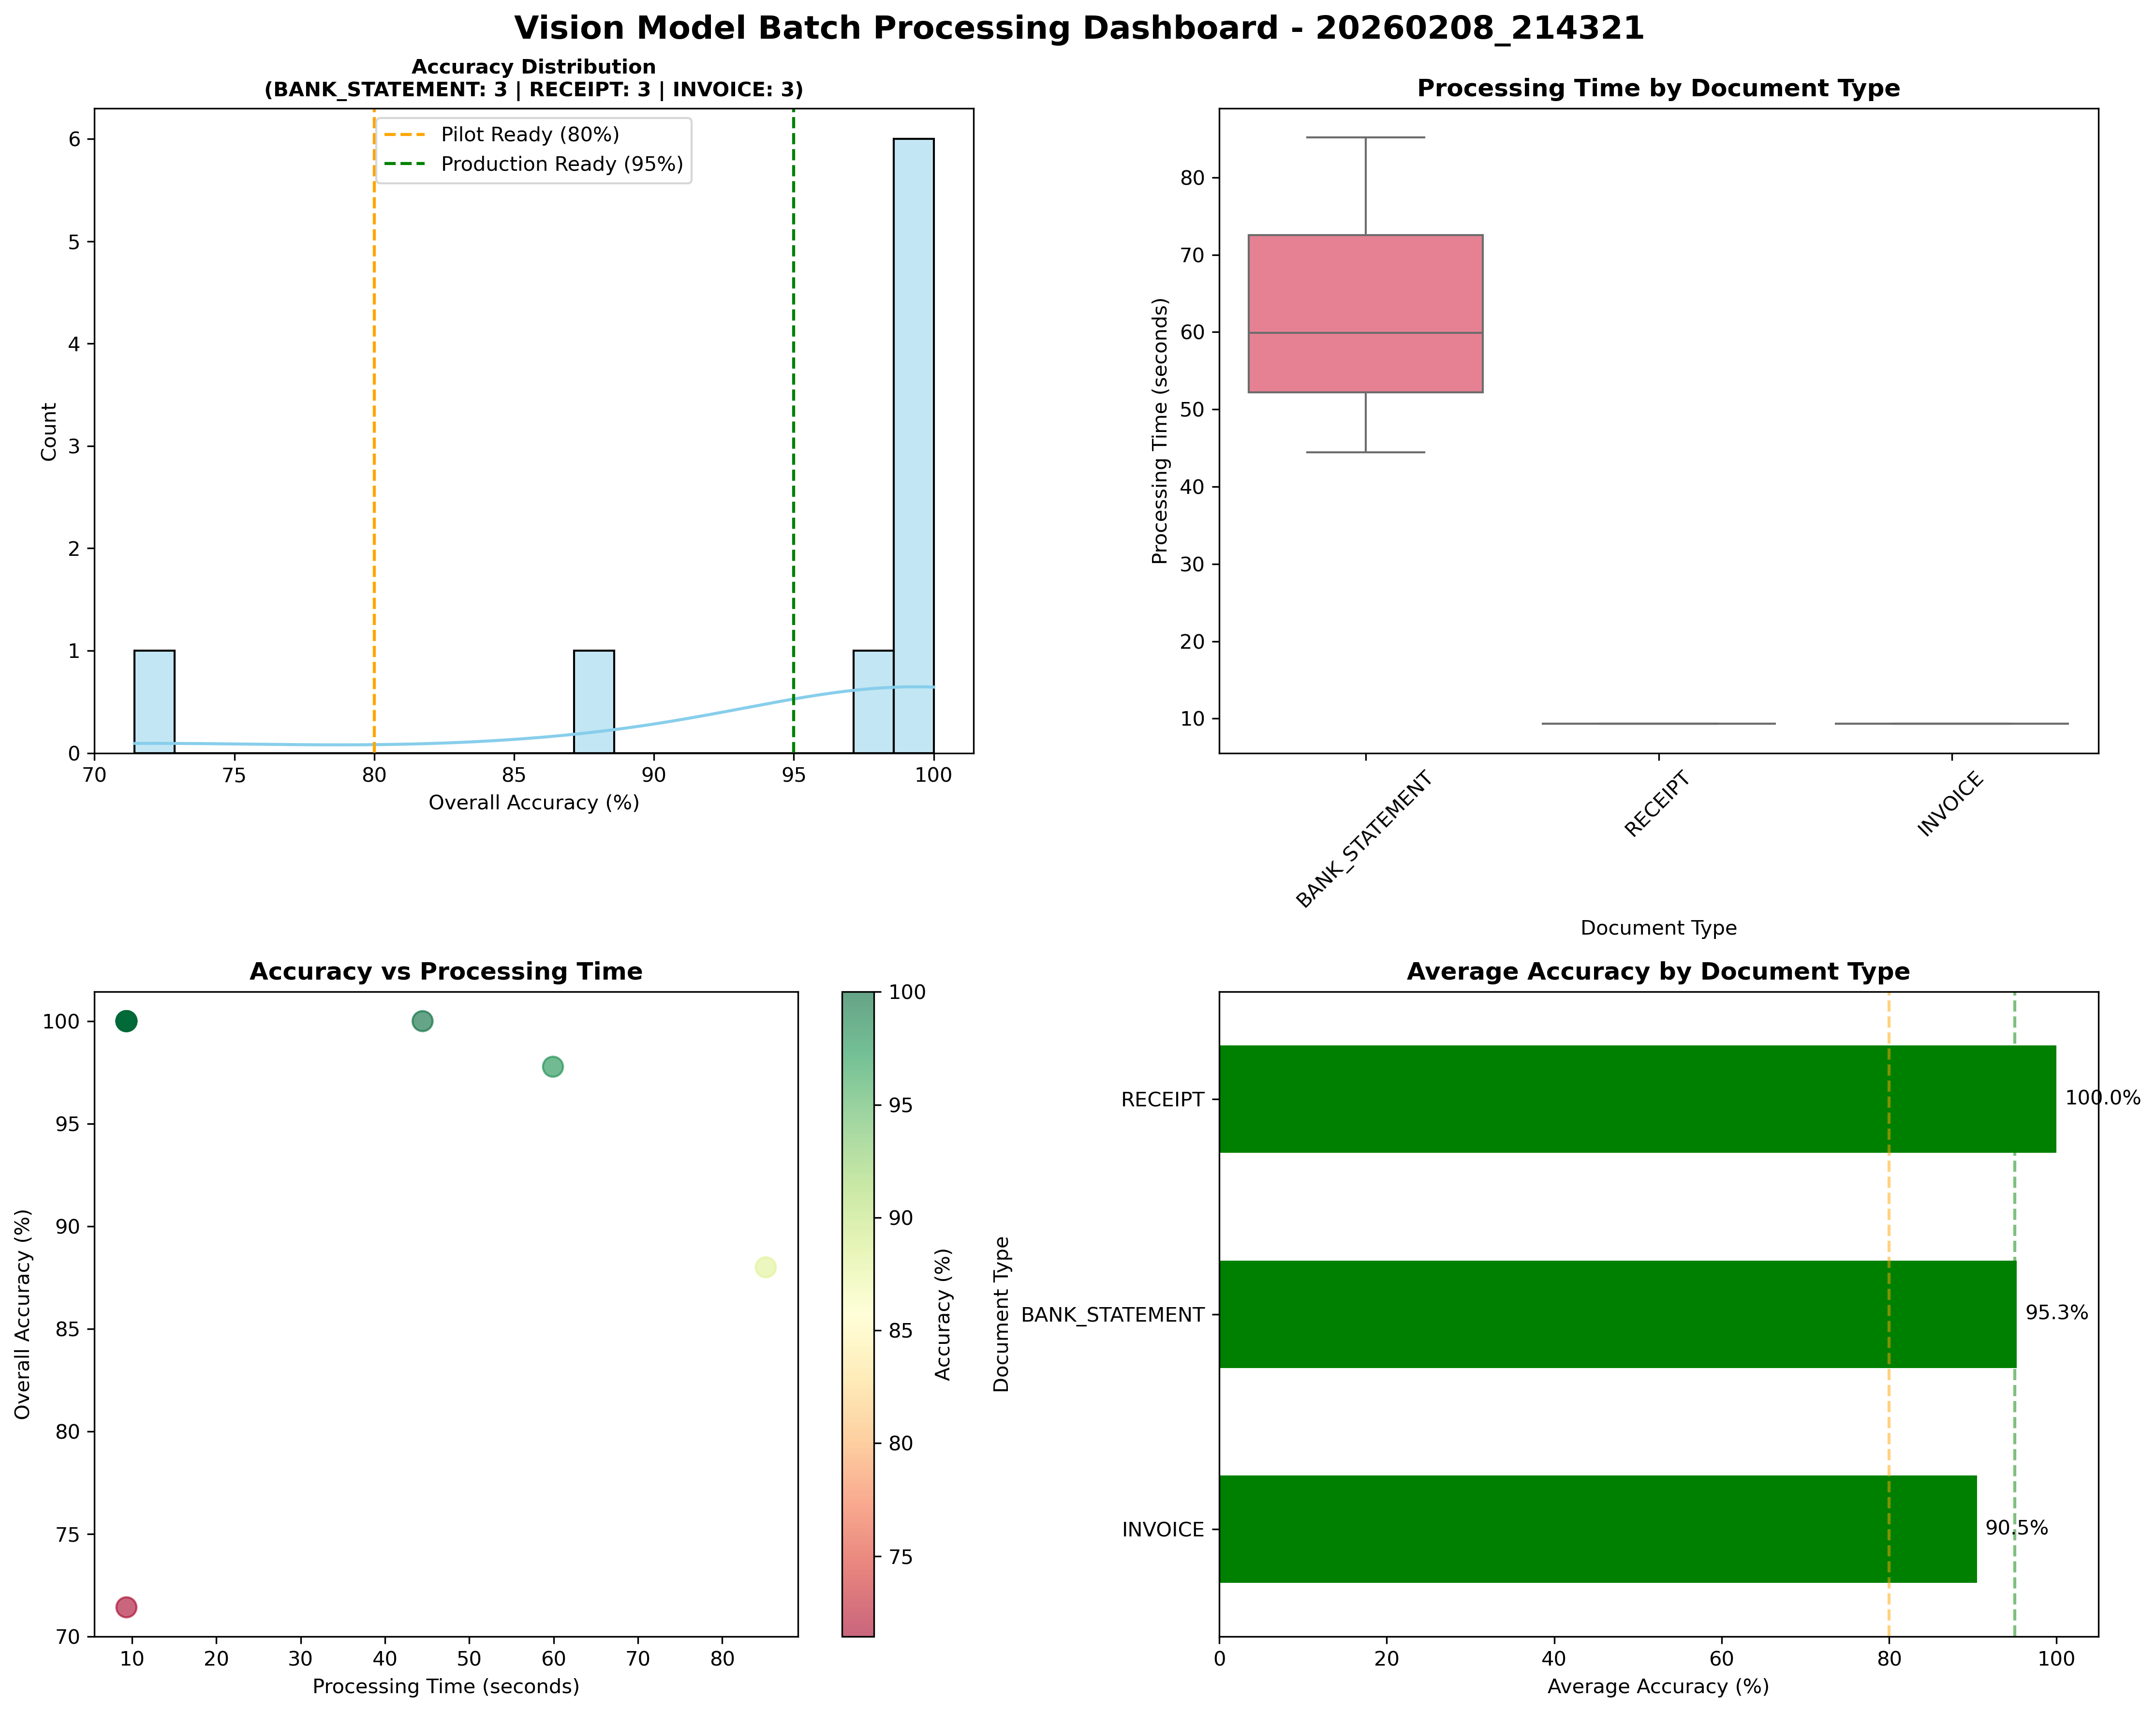

In [13]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3.5-8B Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[blue]🚀 Model: InternVL3.5-8B with Cascade RL and ViR[/blue]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:
    rprint("\n[bold green]🎉 SUCCESS: InternVL3.5-8B processing completed successfully![/bold green]")
    rprint("[green]✅ Enhanced reasoning with Cascade RL is working[/green]")
    rprint("[green]✅ Dynamic resolution adjustment with ViR is active[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 Review error logs for diagnostic information[/red]")
elif avg_accuracy < 30:
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Review extraction results for quality issues[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess performance[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [14]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )
    


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!